In [1]:
import torch

In [2]:
!pip install torchtext==0.6.0

     |████████████████████████████████| 71kB 5.2MB/s 
     |████████████████████████████████| 1.2MB 11.3MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1


In [ ]:
a = torch.ones([10,64,128])
b = torch.ones([64,128])


In [ ]:
a.shape

torch.Size([10, 64, 128])

In [ ]:
b.shape

torch.Size([64, 128])

In [ ]:
a = torch.zeros([2,3])
b = torch.zeros([2,3])
len(torch.nonzero(a))



0

In [ ]:
c

tensor([[1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
c.shape

torch.Size([10, 64, 128])

In [ ]:
d = torch.zeros([10,64,1])

In [ ]:
torch.cat((a,c),dim=-1).shape

torch.Size([10, 64, 256])

In [ ]:
e=a*d

In [ ]:
e.shape

torch.Size([10, 64, 128])

In [ ]:
import spacy

In [ ]:
from torchtext.datasets import Multi30k
from torchtext.data import Field,BucketIterator

In [ ]:
!python -m spacy download en
!python -m spacy download de

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
     |████████████████████████████████| 14.9MB 12.4MB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-cp36-none-any.whl size=14907057 sha256=31f23ab007949a7ad98217b6ac697f9b7327dbf0e026fea9c16e3db6cfa6990d
  Stored in directory: /tmp/pip-ephem-wheel-cache-9oymjsjt/wheels/ba/3f/ed/d4aa8e45e7191b7f32db4bfad565e7da1edbf05c916ca7a1ca
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')


In [ ]:
spacy_eng = spacy.load('en')
spacy_ger = spacy.load('de')

In [ ]:
def tokenize_eng(text):
    return([tok.text for tok in spacy_eng.tokenizer(text)])

In [ ]:
def tokenize_ger(text):
    return([tok.text for tok in spacy_ger.tokenizer(text)])

In [ ]:
english = Field(sequential=True, use_vocab=True, tokenize=tokenize_eng, lower=True,init_token='<sos>',eos_token='<eos>')
german = Field(sequential=True, use_vocab=True, tokenize=tokenize_ger, lower=True,init_token='<sos>',eos_token='<eos>')

In [ ]:
train_data, validation_data, test_data = Multi30k.splits(exts=('.de','.en'),fields=(german,english))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:01<00:00, 1.11MB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 276kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 267kB/s]


In [ ]:
english.build_vocab(train_data,max_size=10000,min_freq=2)
german.build_vocab(train_data,max_size=10000,min_freq=2)

In [ ]:
english.vocab.stoi['<eos>']

3

In [ ]:
english.vocab.itos[5]

'.'

In [ ]:
print(len(english.vocab))
print(len(german.vocab))

5893
7855


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time

In [ ]:
class Encoder(nn.Module):
    def __init__(self,vocab_size,embedding,hidden_size,num_layers):
        super(Encoder,self).__init__()
        self.embedding_size = embedding
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size,embedding)
        self.lstm = nn.LSTM(embedding,hidden_size,num_layers=num_layers)
        
    def forward(self,x,hidden,cell):
                                                     # x : seqlen, batch
        x = self.embedding(x)                   # x : seqlen, batch, embedding   # input lstm : seqlen, batch, input_size
        x,(hidden,cell) = self.lstm(x,(hidden,cell))     # outputlstm : seq_len, batch, num_directions * hidden_size
        return(x,(hidden,cell))
        
    def initHidden(self,batch_size):
        return(torch.zeros([self.num_layers,batch_size,self.hidden_size]))  #hidden : num_layers * num_directions, batch, hidden_size

In [ ]:
class Decoder(nn.Module):
    def __init__(self,vocab_size,embedding,hidden_size,num_layers):
        super(Decoder,self).__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size,embedding)
        self.lstm = nn.LSTM(embedding,hidden_size,num_layers=num_layers)
        self.fc = nn.Linear(self.hidden_size+self.embedding_size,self.embedding_size)
        
    def forward(self,x,c,hidden,cell):
        batch_size = x.shape[0]
        x = self.embedding(x)
        if(len(torch.nonzero(c)!=0)):
            x = torch.cat((x,c.view(batch_size,-1)),dim=-1)
            x = self.fc(x)
        x = x.view(1,batch_size,self.embedding_size)
        x,(hidden,cell) = self.lstm(x,(hidden,cell))
        return(x,(hidden,cell))
        
    def initHidden(self,batch_size):
        return(torch.zeros([self.num_layers,batch_size,self.hidden_size]))

In [ ]:
class Translate(nn.Module):
    def __init__(self,encoder,decoder,hidden_size,output_size):
        super(Translate,self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.softmax = nn.Softmax(dim=0)
        self.dropout = nn.Dropout(0.25)
        self.fc = nn.Linear(2*hidden_size,output_size)
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        
    
    def forward(self,source,target):
        batch_size = source.shape[-1]
        hidden = self.encoder.initHidden(batch_size).to(device)
        cell = self.encoder.initHidden(batch_size).to(device)
        enc_hidden,(hidden,cell) = self.encoder(source,hidden,cell)   # # outputlstm : enc_seq_len, batch, hidden_size  
        
        dec_seq_len = target.shape[0]-1
        enc_seq_len = source.shape[0]
        out = torch.zeros([dec_seq_len,batch_size,self.output_size]).to(device)

        #hidden = hidden.view(num_layers,batch_size,-1)
        #cell = cell.view(num_layers,batch_size,-1)
        c = torch.zeros([batch_size,self.hidden_size]).to(device)
        #Attention procedure. dot product based
        for i in range(dec_seq_len):
    
            dec_hidden,(hidden,cell) = self.decoder(target[i,:],c,hidden,cell) 
            h = dec_hidden[0]              # batch, hidden
            a = torch.sum(torch.mul(enc_hidden,h),axis=-1)  #a = enc_seq_len, batch

            a = self.softmax(a)
            c = torch.sum(torch.mul(enc_hidden,a.view(enc_seq_len,batch_size,1)),axis=0)   #c = batch, hidden
            c = self.tanh(c)

            o = self.fc(torch.cat((c,h),dim=-1))
            out[i,:,:] = o
        
        return(out)

In [ ]:
english_vocab_size = len(english.vocab)
german_vocab_size = len(german.vocab)
embedding = 80
output_size = english_vocab_size
hidden_size = 256
num_layers = 2
batch_size = 128
learning_rate = 0.01
epochs = 6
device='cuda'

In [ ]:
train_iterator, validation_iterator, test_iterator = BucketIterator.splits((train_data,validation_data,test_data),
                                                                          batch_size=batch_size,device=device)

In [ ]:
encoder = Encoder(german_vocab_size,embedding,hidden_size,num_layers)
decoder = Decoder(english_vocab_size,embedding,hidden_size,num_layers)
model = Translate(encoder,decoder,hidden_size,output_size).to(device)
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 5,894,805 trainable parameters


In [ ]:
loss_lst = []
for epoch in range(epochs):
    epoch_loss = []
    t1 = time.time()
    for batch in train_iterator:
        t11 = time.time()
        batch_loss = []
        source = batch.src
        target = batch.trg   #target = encseq_len, batch
        #print(target.shape)
        batch_size = source.shape[-1]
        out = model(source,target)   # out = dec_seq_len, batch, output_size    
        #print(out.shape)
        #print(target.shape)    
        model.zero_grad()
        optimizer.zero_grad()
            
        out = out.view(-1,output_size)
        target = target[1:,:].view(-1)
        #print(out.shape)
        #print(target.shape)  
        loss = criterion(out,target)
        batch_loss.append(loss.item())
            
        loss.backward()
        optimizer.step()
        epoch_loss += batch_loss
        t22 = time.time()
        #print("batch loss : {}  ||  time : {}".format(np.mean(batch_loss),t22-t11))
        print(".",end="")
    loss_lst += epoch_loss
    t2 = time.time()
    print()
    print("mean epoch loss : {}  ||  time : {}".format(np.mean(epoch_loss),t2-t1))

.........................

KeyboardInterrupt: ignored

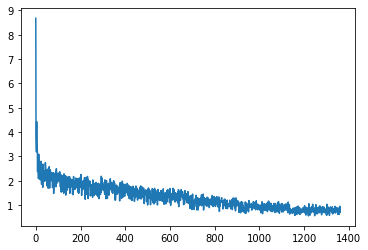

In [ ]:
plt.plot(loss_lst)

In [ ]:
torch.save(model.state_dict(),'Attention_contextToHidden_bidirectional.pth') 

In [ ]:
#sentence = 'ich habe kein interesse am spielen .' # 'i dont have intrest in playing'
#sentence = 'ich bin heute glücklich .'  # 'i am happy today'
sentence = 'eine frau mochte dieses gebäude .' # 'a woman liked that building'
#sentence = 'eines tages werde ich reich sein .'  # 'one day i will be rich'
#sentence = 'ein mann lehnt sich in der nähe einer belebten straße an ein gebäude .'  # 'a man leans against a building near a busy street .'
#sentence = 'wer bin ich .'   # 'who am i'
#sentence = 'ein läufer <unk> sich für ein rennen aus dem <unk> .'  #runner leaving the starting blocks of a race .
sentence = sentence.split()
inputs = torch.zeros([len(sentence)+2],dtype=torch.long)
inputs[0] = 2
inputs[-1]  = 3
#a[1] = 1180
for i in range(0,len(sentence)):
    inputs[i+1] = german.vocab.stoi[sentence[i]]
    
print(inputs)
print(sentence)

tensor([  2,   8,  16,   0, 948, 104,   4,   3])
['eine', 'frau', 'mochte', 'dieses', 'gebäude', '.']


In [ ]:
translation = ''

word = '<sos>'
word_index = 2
enc_seq_len = inputs.shape[0]
dec_seq_len = 1
batch_size = 1
hidden = encoder.initHidden(1)
cell = encoder.initHidden(1)
enc_hidden,(hidden,cell) = encoder(inputs.view(-1,1).to(device),hidden.to(device),cell.to(device))
hidden = torch.cat((hidden[:encoder.num_layers],hidden[encoder.num_layers:]),dim=-1)
cell = torch.cat((cell[:encoder.num_layers],cell[encoder.num_layers:]),dim=-1)
c = torch.zeros([1,2*hidden_size]).to(device)

while(word!='<eos>'):
    dec_hidden,(hidden,cell) = decoder(torch.tensor([word_index]).to(device),c,hidden,cell)
    h = dec_hidden[0]              # batch, hidden
    a = torch.sum(torch.mul(enc_hidden,h),axis=-1)
    a = model.softmax(a)
    c = torch.sum(torch.mul(enc_hidden,a.view(enc_seq_len,batch_size,1)),axis=0)
    c = model.tanh(c)
    o = model.fc(torch.cat((c.view(1,-1),h),dim=-1))
    word_index = torch.argmax(o).item()
    
    word = english.vocab.itos[word_index]
    if(word!='<eos>'):
        translation = translation + " " + word
print(translation)

 a woman is walking briskly to the building .


'gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gathe

In [ ]:
torch.tensor([2,3]).view(2,1).shape

torch.Size([2, 1])